In [1]:
# load Python/Theano stuff
# Show figures inline with the code
%matplotlib inline   

import theano
import theano.tensor as T
import theano.tensor.nlinalg as Tla
import lasagne       # the library we're using for NN's
# import the nonlinearities we might use 
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
from numpy.random import *
from matplotlib import pyplot as plt

import cPickle
import sys

# import kmeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans 


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Load our code

# Add all the paths that should matter right now
sys.path.append('lib/') 
from GenerativeModel import *       # Class file for generative models. 
from RecognitionModel import *      # Class file for recognition models
from NVIL import *                  # The meat of the algorithm - define the cost function and initialize Gen/Rec model

# import our covariance-plotting software
from plot_cov import *


In [3]:
# Use the fast compile option
theano.config.optimizer = 'fast_compile' 

In [4]:
# Choose Simulation Parameters and Generate Data

xDim = 3 # number of latent classes
yDim = 2 # dimensionality of Gaussian observations

_N = 10000

gmm = MixtureOfGaussians(dict([]), xDim, yDim)

[xsamp, ysamp] = gmm.sampleXY(_N)


(10000,)


In [5]:
# Set up Lasagne Recognition Network 

rec_is_training = theano.shared(value = 1) 

rec_nn = lasagne.layers.InputLayer((None, yDim))
rec_nn = lasagne.layers.DenseLayer(rec_nn, 100, nonlinearity=leaky_rectify, W=lasagne.init.Orthogonal())
rec_nn = lasagne.layers.DenseLayer(rec_nn, xDim, nonlinearity=softmax, W=lasagne.init.Orthogonal(), b=-5*np.ones(xDim))
NN_Params = dict([('network', rec_nn)])

recDict = dict([('NN_Params'     , NN_Params)
                ])

In [6]:
# Now we get to try it!

# center our simluated data around the mean
ysamp_mean = ysamp.mean(axis=0)
ytrain = ysamp - ysamp_mean

# construct a BuildModel object that represents the method
opt_params = dict({'c0': -0.0, 'v0': 1.0, 'alpha': 0.9})
model = BuildModel(opt_params, dict([]), MixtureOfGaussians, recDict, GMMRecognition, xDim, yDim)

# Initialize generative model at the k-means solution
km = KMeans(n_clusters=xDim, n_init=10, max_iter=500)
kmpred = km.fit_predict(ytrain)

km_mu = np.zeros([xDim, yDim])
km_chol = np.zeros([xDim, yDim, yDim])
for cl in np.unique(kmpred):
    km_mu[cl] = ytrain[kmpred == cl].mean(axis=0)
    km_chol[cl] = np.linalg.cholesky(np.cov(ytrain[kmpred == cl].T))
    
model.mprior.mu.set_value(km_mu)
model.mprior.RChol.set_value(km_chol)

km_pi = np.histogram(kmpred,bins=xDim)[0]/(1.0*kmpred.shape[0])
model.mprior.pi_un.set_value(km_pi)

# Initialize with *true* means and covariances
# model.mprior.mu.set_value(gmm.mu.get_value()-ysamp_mean)
# model.mprior.RChol.set_value(gmm.RChol.get_value())
# model.mprior.pi_un.set_value(gmm.pi_un.get_value())

print ysamp.shape


(10000, 2)


In [7]:
costs = model.fit(ytrain, batch_size = 20, max_epochs=1, learning_rate = 1e-3)

0.00%
(c,v,L): (-0.000000,1.000000,-85.456045)

(c,v,L): (-33.253095,8473.422232,-27.716979)

(c,v,L): (-37.376995,8648.592888,-21.991161)

(c,v,L): (-31.712482,4973.905639,-23.300150)

(c,v,L): (-23.832037,3219.908533,-19.356151)

(c,v,L): (-17.832261,2015.483865,-11.643690)

(c,v,L): (-14.240040,1148.553659,-7.305131)

(c,v,L): (-12.024682,799.598721,-9.346870)

(c,v,L): (-10.835945,577.411230,-6.219169)

(c,v,L): (-8.834713,401.510782,-9.156276)

(c,v,L): (-5.560051,188.584994,-2.687316)

(c,v,L): (-4.476842,126.877076,-7.062857)

(c,v,L): (-4.217385,119.335149,-3.094500)

(c,v,L): (-3.395855,166.775772,-0.932655)

(c,v,L): (-2.766330,91.004361,0.164641)

(c,v,L): (-2.128487,46.448827,-1.632141)

(c,v,L): (-1.813683,35.390295,-0.592017)

(c,v,L): (-1.415285,21.183007,0.247108)

(c,v,L): (-1.509700,24.734204,0.269481)

(c,v,L): (-1.226693,17.632045,0.104368)

(c,v,L): (-0.996324,10.369491,-1.048532)

(c,v,L): (-0.936800,6.361623,-0.114432)

(c,v,L): (-1.010299,5.505226,0.178992)

(c,

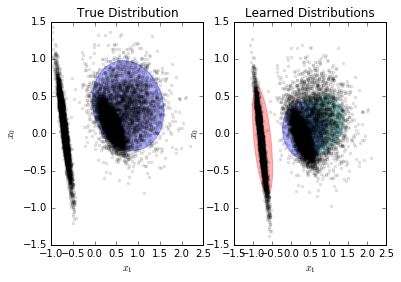

In [8]:
clr = ['b', 'r', 'c','g','m','o']

plt.figure()
plt.subplot(121)
plt.plot(ysamp[:,0], ysamp[:,1],'k.', alpha=.1)
plt.hold('on')
for ii in xrange(xDim):
    Rc= gmm.RChol[ii].eval()
    plot_cov_ellipse(Rc.dot(Rc.T), gmm.mu[ii].eval(), nstd=2, color=clr[ii%5], alpha=.3)
    
plt.title('True Distribution')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')

plt.subplot(122)
plt.hold('on')
plt.plot(ytrain[:,0], ytrain[:,1],'k.', alpha=.1)
for ii in xrange(xDim):
    Rc= model.mprior.RChol[ii].eval()
    plot_cov_ellipse(Rc.dot(Rc.T), model.mprior.mu[ii].eval(), nstd=2, color=clr[ii%5], alpha=.3)
    
plt.title('Learned Distributions')    
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')

plt.show()

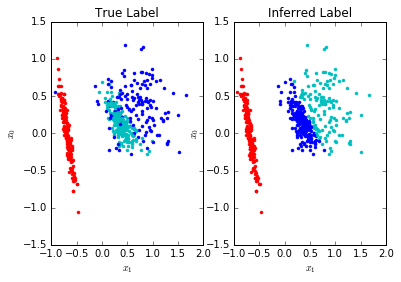

In [9]:
xlbl = xsamp.nonzero()[1]
#learned_lbl = model.mrec.h.eval({model.Y:ytrain}).argmax(axis=1)
#learned_lbl = model.mrec.getSample(ytrain).argmax(axis=1)
learned_lbl = model.mrec.h.argmax(axis=1).eval({model.Y:ytrain})

clr = ['b', 'r', 'c','g','m','o']

plt.figure()
for ii in np.random.permutation(xrange(500)):
    plt.subplot(121)
    plt.hold('on')
    plt.plot(ysamp[ii,0] ,ysamp[ii,1],'.', color = clr[xlbl[ii]%5])
    plt.subplot(122)
    plt.hold('on')
    plt.plot(ysamp[ii,0] ,ysamp[ii,1],'.', color = clr[learned_lbl[ii]%5])
    
plt.subplot(121)
plt.title('True Label')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
plt.subplot(122)
plt.title('Inferred Label')
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
    
plt.show()


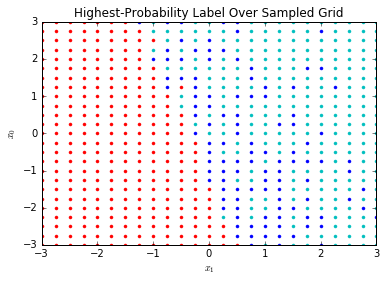

In [10]:
n = 25

x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)
xv, yv = np.meshgrid(x, y)
grid= np.vstack([xv.flatten(), yv.flatten()]).T

gridlabel = model.mrec.getSample(grid).argmax(axis=1)

plt.figure()
plt.hold('on')
for ii in xrange(n*n):
    plt.plot(grid[ii,0] ,grid[ii,1],'.', color = clr[gridlabel[ii]%5])
plt.ylabel(r'$x_0$')
plt.xlabel(r'$x_1$')
plt.title('Highest-Probability Label Over Sampled Grid')
plt.show()